# 1. 概述

一段较为基础的训练代码包括以下几个部分：

1. 导入各种包

2. 数据准备：`Dataset`和`DataLoader`，前者把训练用的数据打包成一个对象，后者从这个对象里面把数据一个个调出来扔进模型里面。

3. 定义神经网络的class，包括两步：

    创建一个class，这个class从`nn.Module`这个class中继承，使用Sequential()定义模型结构。
    
    为class定义一个`forward()`方法，用作前向传播。

4. 定义训练函数`train()`和测试函数`test()`

5. 设置参数并开始训练，比如下面通过一个`for-in`循环，一个循环就是一个`epoch`。

6. 展示训练结果。

# 2. 导入各种包

## 基础回顾：

`library`，包：一个文件夹，里面包含多个.py文件，其中一个必定以`__init__.py`命名。也可以包含文件夹，文件夹里面再包含`.py`文件

`module`，模块：一个`.py`文件，里面就是各种代码，一般就是各种类`class`和各种`method`。

`library`和`module`都可以被`import`，通常一个包里面还有套娃，如果只是想调用一个在多层套娃的包中的一个模块里面的某一个类，就要就要写很长很长，所以一般写个缩写，比如：

`import pandas as pd`

python表示图片有多种形式：`PIL Image`和`numpy.ndarray`。但归根结底，它们都是matrix

`ToTensor`方法用于把`PIL Image`类型和`numpy.ndarray`类型转为`tensor`类型以方便处理。

转换之前，图片像素的值域是`[0, 255]`（整数值），转换之后，图片的一个像素的值域是`[0.0, 1.0]`（浮点数）。




In [ ]:
import torch # torch是一定会用到的，pytorch的核心就是torch这个包。
from torch import nn # nn是一个具体的module，也就是一个.py文件，由于里面的各种类和方法可能都会被用到，因此全部导入。nn.Module这个类用于构建神经网络。
from torch.utils.data import DataLoader # DataLoader是一个类，torch.utils.data这个模块里面有很多类，但不是每个类都会用到，因此只导入必要的类。
from torchvision import datasets # torchvision、torchtest、torchaudio都是和torch同一层级的包，针对不同的任务，封装了不同的模块、类、函数，以及训练数据。

from torchvision.transforms import ToTensor

# 3. 数据准备

使用`torchvision`下载数据，并把数据通过`ToTensor`方法转换为`Tensor`对象，方便后面处理
以及将得到的数据变成一个类，方便后面放进`DataLoader`。

这里由于用的是pytorch内置的数据集，所以它为内置的数据集提供了一个开箱即用的`module`（class）。如果是导入自己的数据集，这一个模块可能就要自己写，比如参考李宏毅的hw01。 

总结一下，数据准备的模块需要实现以下几个功能：

0. 数据下载：这一部分可能放在这一模块里面，也可能分开，或者手动上传。
1. 数据清洗：去掉无价值的数据。这一部分也可能手动完成。
2. 把数据划分为训练集、测试集、验证集。这里没有验证集。
3. 把数据转换成`Tensor`对象。针对图片、声音、结构化的数据，调用不同的转换方法。


In [ ]:
training_data = datasets.FashionMNIST(
    root = "data", # 把数据下载到 /data 目录下。
    train = True, # 选择True会下载训练集，选择False会下载测试集。
    download = True, # 下载数据
    transform = ToTensor(), # 下载得到的数据是 PIL Image 类型，用ToTensor()方法来转换成Tensor类型的图片。
)


test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
)

# 4. 数据加载模块 `DataLoader`

*`DataLoader`直接调用模块就好。*

`DataLoader`本质上也是一个`Iterable`。

打个比方：由于训练的数据非常大，不可能一次全部吃完，要分几次吃——如何分？分多少次？每次吃多少？另外由于要放在GPU上训练，就要先写入GPU的显存里面等。这些工作，神经网络不会自动完成，要靠一个额外的机制来实现，所以就请来一个保姆，这个保姆就叫`DataLoader`。

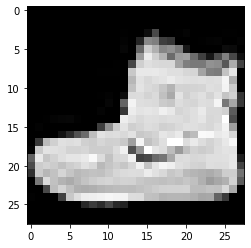

100 个batch
60000 个样本


'\n# 这里可以看出每次调用train_dataloader，返回64张图片，每张图片1个通道，28 * 28像素，以及每张图片的label\nfor X, y in train_dataloader:\n  print(X.shape)\n  print(y.shape)\n'

In [ ]:
batch_size = 600 # 训练的BatchSize大小，一次给模型全部图片训练，给完所有图片，完成一个epoch。

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)


# 从DataLoader里面拿一张图片出来看
# dataloader不是一个iterator，所以用iter()函数转成iterator，再用next()调用取得其所有值。
train_features, train_labels = next(iter(train_dataloader)) 


# torch.squeeze()方法是对数据进行压缩，去掉维数为1的维度
test_img = train_features[0].squeeze()
plt.imshow(test_img, cmap = "gray")
plt.show()

print(len(train_dataloader), "个batch")
print(len(train_dataloader.dataset), "个样本")

'''
# 这里可以看出每次调用train_dataloader，返回64张图片，每张图片1个通道，28 * 28像素，以及每张图片的label
for X, y in train_dataloader:
  print(X.shape)
  print(y.shape)
'''



# 5. 构建模型

## 基础回顾

super()函数与继承有关，用于将父类的所有属性都继承过来。如果不设定变量名，就是把父类全部属性原封不动继承过来。如果设定变量名，就会按顺序生成映射。

比如：__init__(self, a1) 内绑定属性 a1 ，并通过 super().__init__(a1) 用子类的 a1 属性替换掉从父类继承过来的第一个属性。

也可以通过 super().__init__(a1, a1, a1) 这样的写法，用子类的a1属性替换掉从父类继承过来的第一、二、三个属性，依次类推。

关于super()的详细用法，可以参考：https://realpython.com/python-super/#an-overview-of-pythons-super-function

## 模型内容

从nn.Module这个class中继承属性和方法

`nn.Sequential()`模块是一个抽象概念上的“container”，其作用是按照传入该模块的顺序，将神经网络的各神经层连起来。

`Sequential`对象可世界接受输入数据，如下，`forward`函数直接向`Sequential`输入被`Flatten`“拍扁”后的数据

注意`Sequential`中的层的顺序，**确保前一个层的输出的大小等于后一个层的输入的大小。**

除了`Sequential`外，还有其他方法组织神经层，如`OrderedDict`，`ModuleList`，此处先不展开。

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    self.flatten = nn.Flatten()

    self.linear_relu_stack = nn.Sequential(
        # 一层Linear和一层ReLU组成一个符合理论定义上的、完整的神经层。
        nn.Linear(28*28, 512), # 使用全链接层，下同。这里可理解为表示：接受28*28个输入要素，输出512个要素。
        nn.ReLU(), # 使用ReLU()作为激活函数，下同。这可理解为：接受上一层神经层输出的512个要素，每个要素都被输入一个ReLU函数。

        nn.Linear(512, 512), # 从上一层的ReLU函数的输出值
        nn.ReLU(),

        nn.Linear(512, 512),
        nn.ReLU(),

        nn.Linear(512, 10)
    )

  # 调用forward函数执行前向传播
  # 不能直接使用 Module.forward() 具体原因还没搞清楚，官方文档对此有说明。
  def forward(self, x):
    x = self.flatten(x) # Flatten函数将高维矩阵"拍扁"，默认参数(1, -1)。
    logits = self.linear_relu_stack(x)
    return logits # 返回前向传播的结果


# 6. 训练和测试用的函数

对这部分的讲解，这个博客很好：

> https://programming-review.com/pytorch/train

阅读此部分最好对神经网络中梯度下降的知识有所理解，比如能推导一个简单的单层神经网络的反向传播的过程。

In [ ]:
# 训练函数
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # 总共有多少个训练样本，dataset是把所有样本都读取进一个Iterable里面
    
    # 调用nn.Module的train()方法，目的在于告诉模型进入"训练状态"。
    # 下方的test函数的model.eval()是让模型进入"测试状态"，这两种状态二选一，即 model.train(False) 等同于model.test()
    # 这两种状态主要影响某些类型的神经层，如Dropout和BatchNorm
    model.train()
    
    # enumerate()同时返回iterable的index和value，此处将index给batch，表示这个batch的下标，value给(X, y)这个tuple
    # X是一个batch里面，所有样本图片，组成的一个Tensor列表，y是对应的标签label组成的Tensor列表
    for batch, (X, y) in enumerate(dataloader): 
        X, y = X.to(device), y.to(device) # 把从DataLoader中获取的Tensor变量复制一份放进GPU，后面对变量的操作都在GPU上运行

        # 前向传播
        pred = model(X) # 获取模型前向传播的值，此处的pred是一个Tensor列表
        loss = loss_fn(pred, y) # 把前向传播的值和真实值放进损失函数中，计算差值。此处loss是只有一个元素的Tensor

        # 反向传播
        # 梯度清零【重点】
        optimizer.zero_grad()
        # 梯度即为损失函数loss function对神经网络每一个权重weight的导数的"集合"
        # pytorch是默认不清空梯度，实现梯度累加的。好处是可以实现多个batch训练得到的梯度累加，等价于大batch训练时候的梯度，极大节省内存。变相弥补了在显存不足而不得不减少batchsize时的缺陷。
        # 可以看这里：https://www.zhihu.com/question/303070254
        # 具体的做法是在此处加一个判断语句，判断累加了多少个batch再进行反向传播更新参数
        # 但梯度不能一直累加，否则相当于无限大的batch_size。所以每次执行反向传播之前先清空梯度，防止本次反向传播受到上一次的梯度的影响。

        loss.backward() # 执行反向传播，计算梯度
        optimizer.step() # 根据梯度更新weight和bias

        if batch % 100 == 0: # 判断batch的下标，如果为100（执行到第101个batch），无论还有多少个batch，先打印一下当下batch的训练结果。后面每200、300……打印一次结果。在batchsize过小单个epoch训练时间过长时及时查看结果。
            loss, current = loss.item(), batch * len(X) # loss是一个只有一个元素的Tensor，使用iter()提取出来；current表示现在训练到第几个样本
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# 测试函数
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # 见上，这里用的test_dataloader
    num_batches = len(dataloader) # 多少个batch，这里用的test_dataloader
    model.eval() # 见上

    test_loss, correct = 0, 0 # 初始化参数：错误率、准确率

    with torch.no_grad(): # no_grad()表示禁止模型计算梯度，特别是不需要执行反向传播————比如loss.backward()的时候。
        for X, y in dataloader: # 见上
            X, y = X.to(device), y.to(device) # 见上

            pred = model(X) # 前向传播，返回一个Tensor列表，列表中每一个元素就是对一个batch内每一个样本的预测值

            test_loss += loss_fn(pred, y).item() # 把每一次前向传播得到的loss都加起来
            # 因为loss_fn(pred, y)返回的是一个Tensor对象，而.item()方法是从Tensor中获取单个元素。只有当Tensor中只有一个元素时才能这样调用，否则报错

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # 把每一个batch的分类结果与label(y)对比作判断，返回一个Tensor列表，列表元素为True或者False；使用type(torch.float)方法对各元素强制转为浮点数类型1.0或者0.0；使用sum()函数对所有元素累加；使用iter()从Tensor中提取累加后的唯一值
            # argmax()方法返回Tensor对象的最大的值的下标。输入的参数表示查看哪个维度的元素。如这里输入1表示查看第2个维度。返回的是这个维度的每个list里面最大的元素的下标。
            # 由于预测的值使用独热编码，所以每一个样本输出的结果就是一个list，这个list只有一个元素为1其余元素均为0，所以这个list的最大的元素的下标就是对应label转为独热编码之前的值
            # 这里也可以看出独热编码的好处！！！独热编码得到的list，调用argmax()，返回的下标就直接对应独热编码之前的值
            # 更多内容查看官方文档：https://pytorch.org/docs/stable/generated/torch.argmax.html
          

    test_loss /= num_batches # 上面得到的test_loss，是每一个batch的loss的累加，因此要除以batch数量，得到每个batch的平均loss
    correct /= size # 上面得到的准确率是每一个样本的准确率的累加，除以样本数量，得到每个样本平均准确率

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n") # 每个epoch结束后打印结果


# 7. 设置训练参数，用for-in循环开始训练


In [ ]:
device = "cuda" # 用什么设备来跑。
model = NeuralNetwork().to(device) # 创建一个实例，并将它放到硬件（cpu或者gpu）上运行。
print(model) # 看一下模型的结构。

loss_fn = nn.CrossEntropyLoss() # 定义loss function；设置weight和bias的初始值。

optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3) # 选择梯度下降的方式，此处选择 SGD 随机梯度下降：torch.optim.SGD()，同时设置学习率。

epochs = 100 # 训练多少轮


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

# 8. 保存模型

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

# 9. 重新加载模型

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


# `nn.Flatten` vs `torch.flatten`：

`nn.Flatten`的作用是把n维对象拍扁成2维。

`torch.flatten`的作用是把n维对象拍扁成1维。

`torch.flatten`是一个方法，可以直接调用。`nn.Flatten`是一个对象，不能直接调用，要先创建一个`nn.Flatten`实例，再通过该实例去操作数据。

此处给出一个test2作为例子，可以看成3张图片，每张图片2个通道，2行的pixel，每行有3列pixel的一个“小数据集”。

经过`nn.Flatten`之后，得到3*12的一个2维矩阵。

经过`torch.flatten`后，得到一个只有1维的list

`nn.Flatten`在创建实例时，有两个默认参数：1, -1，表示从第2个维度（永远记得计算机从0开始数）开始，到最后一个维度（-1表示最后一个维度）结束，这中间的所有维度被拍扁，变成1维。从数学来说，就是：第2个维度的特征数 X 第3个维度的特征数 X …… X 最后一个维度的特征数。

如下的test2，是一个3*2*2*3的矩阵，创建`nn.Flatten`实例`fla`，并将该实例应用于该矩阵：第1个维度的特征数不变，3个特征；从第2到第4个维度分别有2、2、3个特征，乘积为12，故最后输出一个3 X 12的矩阵。

再如创建一个`fla2`的实例，自定义参数(0, -1)，意为从第1个维度到最后一个维度都被拍扁成为1个维度，得到一个1行36列的tensor list。

`torch.flatten`也可以指定从哪个维度开始从哪个维度结束，用法同上，限于篇幅暂不展开。

In [ ]:
import torch
from torch import nn

# test1可被看作1张图片，1个通道，2行3列的pixel
test1 = torch.tensor([[1,2,3], 
                      [4,7,8]])

# test2可被看作3张图片，每张图片2个通道，每张图片是2行3列的pixel。
test2 = torch.tensor([
            [[[7,1,8],
              [1,2,3]],

              [[9,2,5],
              [1,3,3]]],

            [[[80,10,80],
              [10,20,30]],

             [[90,20,50],
              [10,30,30]]],

            [[[7,20,3],
              [10,1,3]],
             
             [[6,2,2],
              [36,2,25]]]
            ])

# 查看维数
print("\nShape of test1:\n", test1.shape)
print("\nShape of test2:\n", test2.shape)

# Case 1 使用torch.flatten()处理
print("\nShape of test1 by torch.flatten:\n", torch.flatten(test1).shape)
print(torch.flatten(test1))

print("\nShape of test2 by torch.flatten:\n", torch.flatten(test2).shape)
print(torch.flatten(test2))


# Case 2 使用nn.Flatten()模块处理
fla = nn.Flatten()
flatest1 = fla(test1)
flatest2 = fla(test2)

print("\nShape of test1 by nn.Flatten:\n", flatest1.shape)
print(flatest1)

print("\nShape of test2 by nn.Flatten:\n", flatest2.shape)
print(flatest2)


# Case 3 自定义拍扁从第几个维度开始，第几个维度结束
fla2 = nn.Flatten(0, -1)
fla2test2 = fla2(test2)
print("\nShape of test2 by fla2:\n", fla2test2.shape)
print(fla2test2)


# 卷积神经网络的例子

In [ ]:
import torch.nn.functional as F


# 创建一个卷积网络
class covnet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5) # Conv2d()用于创建2D的卷积网络层。
    self.conv2 = nn.Conv2d(20, 20, 5)

  def forward(self, x):
    x = F.relu(conv1(x))
    return F.relu(conv2(x))


# 数据集模块 `Dataset`

`Dataset`和`DataLoader`本质上都是`Iterable`

## 基础回顾：

带有下划线的函数方法，如`__something__`，代表这是一个特殊变量（方法、属性），不同于私有变量，它虽然可以被直接访问，但最好不要这样做。因为这些特殊方法通常对应某些python内置的函数。让自定义的对象可以被某些python内置的方法所调用。如下文提到的`__len__`

参考廖雪峰python教程有关定制类和高级特性的内容：

> https://www.liaoxuefeng.com/wiki/1016959663602400/1017590712115904

> https://www.liaoxuefeng.com/wiki/1016959663602400/1017269809315232

### `Iterator`和`Iterable`的区别：

1. `Iterable`和`Iterator`都可以通过`for-in`被调用

2. `Iterator`可以被`next()`调用，不断返回下一个值。这种计算是惰性的，同时`Iterator`不能提前知道其内部有多少要素。也就是“需要的时候我才拿出来给你，平时你休想知道我有多少私房钱！”。**Iterator可以是无限元素的，可将其视为源源不断的数据流（当然也可以是有限的，主要和`Iterable`区别开）**

3. `Iterable`不能被`next()`调用，但是可以通过`len()`方法知道其内部有多少要素。**Iterable一定是有限的**

4. `Iterable`可使用下标`[]`分量取值和`:`切片

5. `Iterable`可以通过`iter()`方法转为`Iterator`

以上只是从其外部表现来区分二者，从内部来看，是二者所包含的方法的区别，以下分点与上述分点对应：

1. 因为二者都有`__iter__()`方法，`for-in`循环就是调用该方法。
    
   `for-in`循环的本质是对`Iterator`使用`next()`计算下一个返回值。

   `for-in`循环执行时，如果是对`Iterable`，就先调用`__iter__()`，返回一个`Iterator`，再使用`next()`计算其下一个返回值；如果是`Iterator`就返回其自身，再使用`next()`计算其下一个返回值。

2. `Iterator`可直接在类的外部调用`__next__()`方法。

3. `Iterable`独有`__len__()`方法。

4. `Iterable`独有`__getitem__()`方法。一个对象如果没有`__iter__()`，但是有`__getitem__()`，也可被视为是`Iterable`。

5. 同第1点，都是因为二者都有`__iter__()`,在类的外部调用`iter()`时候返回其自身`Iterator`。

**`Iterable`可视为在`Iterator`基础上的又一层封装：不让外部直接调用`next()`方法，增加`__len__()`和`__getitem__()`。**

更多内容可参考：

> https://www.cnblogs.com/guxh/p/10235220.html


`Dataset`的意义在于其可以通过索引获取对应的值。

*这一部分对于这个官方的case来说不是必要的，只有当使用自己的数据的时候才要自定义dataset。在李宏毅的hw01中，因为用的是自己上传的数据，所以要自己写dataset。*

一个Dataset至少包含三个方法：`__init__()`, `__len__()`, `__getitem__()` 

1. 任何一个类都会有`__init__()`方法，用于绑定类的属性。

2. `__len__()`对应`len()`方法，用于获取某个实例又多少元素

3. `__getitem__()`可以通过输入下标获取对应内容，如`istance[n]`，获取`istance`这个实例下标为`n`（从0开始数）的内容。

`transform`用来将`image`转换成高维的`tensor`矩阵。一般直接用 `transform = ToTensor()`

`target_transform`用来将整数值的标签转换为独热编码`one-hot encoded`。一般使用：

```
target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
```

这里的10是对应本数据集具有10个不同的类别。

In [ ]:
import os 
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class custom_dataset(Dataset): # 自定义dataset一般从Dataset继承
  def __init__(self, annotations_file, img_dir, transform = None, target_transform = None):
    self.img_lables = pd.read_csv(annotations_file) # 标签数据是一个n行2列的csv格式的"表"，使用pd.read_csv()方法，将其读取成为一个DataFrame类型的数据。
    self.img_dir = img_dir # 样本数据的存储目录，如 '/home/test/train_image/'
    self.transform = transform # 绑定一个方法用于转换数据，比如ToTensor(): 把PIL Image或ndarray转为值域为[0.0-1.0]的tensor对象.
    self.target_transform = target_transform # 同上。


  def __len__(self): # 拥有__len__()方法的对象，能通过 len() 获得实例的元素的个数。
    return len(self.img_labels) # 获取img_labels这个dataframe有多少行,即有多少样本。


  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) # img_labels 这个csv文件的第一列（下标为0）是文件名；os.path.join()根据文件所在的路径，以及文件名，获取文件的完整路径
    image = read_image(img_path) # 根据img_path路径，调取图片，放到image这个变量里面。这一步可以理解为从磁盘读取数据到计算机的内存。
    label = self.img_labels.iloc[idx, 1] # 同上。用iloc方法提取第二列，第二列是每张图片的标签。在这里标签都是整数，方便转为one-hot coding。

    if self.transform: # 如果transform被定义，就用这个方法转换图片。
      image = self.transform(image)
    if self.target_transform: # 同上
      label = self.target_transform(label)

    return image, label # 以tuple形式返回值
  